In [ ]:
# matplotlib 한글 깨짐방지
# 아래코드 실행후 '런타임 다시시작' 후 모듈 불러오기

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# **1. 데이터 불러오기**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
np.set_printoptions(suppress = True)

In [3]:
plt.rcParams['font.family'] = 'NanumBarunGothic' #matplotlib 한글 깨짐 방지

- 현재 데이터는 댐별로(지역별로) 구분하여 4개의 그룹으로 나눠져 있는 상태
  - group 1: 섬진강, 용담, 임하, 주암(본), 합천
  - group 2 소양강, 충주
  - group 3: 군위, 김천부항, 남강, 밀양, 보령, 보현산, 부안, 성덕, 영주, 장흥, 주암(조), 횡성
  - group 4: 대청, 안동

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
 # 파일 저장 경로 설정
save_path = '/content/drive/MyDrive/2023년 K-water 대국민 물 빅데이터 분석과제 공모전/final/data'

In [6]:
# 데이터 파일 경로 저장
train_files = [os.path.join(save_path, f'train_group{i}.csv') for i in range(1, 5)]
test_files = [os.path.join(save_path, f'test_group{i}.csv') for i in range(1, 5)]

# 각 파일을 데이터프레임 형태로 불러오기
train_groups = [pd.read_csv(file) for file in train_files]
test_groups = [pd.read_csv(file) for file in test_files]

In [7]:
train_groups[0].head(3)

,rain_qy,inflow_qy,outflow_qy,reserve_qy,reserve_rt,tot_qy,valid_qy,unused_qy,maximum_use_qy,avg_hmd,...,dam_nm_주암(조),dam_nm_횡성,year_2019,year_2020,year_2021,year_2022,season_autumn,season_spring,season_summer,season_winter
0,0.000000,0.000000,0.732368,3.022033,0.401,48.7,40.1,5.5,40.1,0.441,...,0,0,1,0,0,0,0,0,1,0
1,0.000000,0.094401,0.926241,3.418644,0.606,48.7,40.1,5.5,40.1,0.479,...,0,0,0,1,0,0,1,0,0,0
2,2.847029,0.304539,0.569849,3.145358,0.456,48.7,40.1,5.5,40.1,0.665,...,0,0,0,0,1,0,0,1,0,0


In [8]:
test_groups[0].head(3)

,rain_qy,inflow_qy,outflow_qy,reserve_qy,reserve_rt,tot_qy,valid_qy,unused_qy,maximum_use_qy,avg_hmd,...,dam_nm_주암(조),dam_nm_횡성,year_2019,year_2020,year_2021,year_2022,season_autumn,season_spring,season_summer,season_winter
0,0.996838,0.189794,0.863312,27.9460,0.574,48.7,40.1,5.5,40.1,0.761,...,0,0,0,0,1,0,0,0,1,0
1,0.000000,0.169743,0.832039,17.7640,0.365,48.7,40.1,5.5,40.1,0.650,...,0,0,1,0,0,0,0,0,1,0
2,0.000000,0.000000,0.214305,14.6331,0.301,48.7,40.1,5.5,40.1,0.744,...,0,0,0,0,0,1,1,0,0,0


- 데이터가 제대로 불러와 진 것을 확인할 수 있다.

### **✅ Data Description**
1. rain_qy: 강우량
2. inflow_qy: (물의) 유입량
3. outflow_qy: (물의) 방류량
4. reserve_qy: (현재) 저수량 (**target** 변수)
5. reserve_rt: 저수율(저수량 / 총저수량)
6. tot_qy: 총저수량
7. valid_qy: 유효저수량
8. unused_qy: 비활용용량
9. maximum_use_qy: (최대) 이수용량
10. avg_hmd: 평균습도
11. avg_tmr: 평균온도
12. avg_wv: 평균풍속
13. sun_sum: 합계일사량
14. dam_nm_OO: 댐이름(범주형 변수)
15. year_OO: 연도(범주형 변수)
16. season_OO: 계절(범주형 변수)

# **2. 평가 지표**
**1) RMSE(Rooted Mean Square Error)**  
- 회귀 모델의 성능을 평가하는 지표 중 하나로, 예측된 값과 실제 값 사이의 오차를 측정
  - 오차를 제곱하여 평균을 구한 뒤 다시 제곱근을 취한 값으로 계산
- 수식  
  $RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2}$  
  - N: 총 데이터 포인트의 개수
  - y_i: 실제 값(observed)
  - y_hat: 예측된 값(fitted)
- 예측 오차가 클수록 더 큰 패널티를 받음
  - RMSE가 작을수록 모델의 예측이 더 정확하다고 판단할 수 있음


**2) Adjusted R-Sqaure(수정 결정계수)**    
- R-Square(결정계수)
  - 모형의 설명력을 의미
  - 회귀식을 통해 얻어진 예측값(fitted)이 실제 y값(observed)을 얼마나 잘 설명하는지를 의미
- 결정계수는 독립변수의 유의성과 무관하게 독립변수의 개수에 비례하여 높아진다는 단점이 존재
  - 이러한 결정계수의 단점을 보완하기 위해 수정 결정 계수 활용
  - 실제로 유의미한 예측 변수가 모델에 포함되었을 때만 R-squared가 증가하도록 합
  - 보통 결정계수에 비해 조금 더 작은 값으로 산출됨
  - 수식  
  $Adjusted\ R^2 = 1 - \frac{(1 - R^2) \times (n - 1)}{(n - k - 1)}$  
    - n: 총 데이터 포인트의 개수
    - k: 모델에 포함된 독립 변수의 개수
    - R^2: R-Square 값



In [9]:
from sklearn.metrics import mean_squared_error, r2_score

# **3. 모델별 성능 확인을 위한 함수**

In [10]:
colors = [
    'khaki', 'teal', 'orchid', 'sandybrown', 'greenyellow', 'dodgerblue', 'rosybrown',
    'deeppink', 'salmon', 'olivedrab', 'olive', 'forestgreen',
    'royalblue', 'mediumpurple', 'gold', 'seagreen',
    'turquoise', 'steelblue', 'slategray', 'peru', 'slateblue', 'cadetblue',
    'lime', 'lavender', 'lightcoral', 'lightseagreen', 'lightskyblue', 'lightgreen',
    'lightpink', 'lightsalmon', 'lightsteelblue', 'lightyellow', 'palegreen',
]

In [11]:
## 회귀곡선 시각화
# 예측값, 실제값을 산점도로 표현

def plot_predictions(name_, pred, actual):
  df = pd.DataFrame({'prediction': pred, 'actual': actual})
  df = df.sort_values(by='actual').reset_index(drop=True)

  plt.figure(figsize=(10, 8))
  plt.scatter(df.index, df['prediction'], marker='x', color='b')
  plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
  plt.title(name_, fontsize=15)
  plt.legend(['prediction', 'actual'], fontsize=12)
  plt.show()

In [12]:
# 평가 지표 시각화
def model_eval(name_, pred, actual):
    global my_predictions
    global colors

    plot_predictions(name_, pred, actual)

    rmse = np.sqrt(mean_squared_error(pred, actual))

    n = len(actual)  # 데이터 개수
    p = 15  # 변수의 개수
    r2 = r2_score(actual, pred)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    my_predictions[name_] = {'rmse': rmse, 'Adjusted R_2': adjusted_r2}

In [13]:
def visualize_model_evaluations():
    global my_predictions
    global colors

    # 데이터프레임 생성
    df = pd.DataFrame(my_predictions).T
    df = df.sort_values(by=['rmse', 'Adjusted R_2'], ascending=[True, False])

    # 상한, 하한 설정
    min_ = df['rmse'].min() - 10
    max_ = df['rmse'].max() + 10

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()

    # 수정된 부분: np.arange(len(df)) 대신 range(len(df))를 사용하여 오름차순 순서로 바 그래프 위치 지정
    ax.set_yticks(range(len(df)))
    ax.set_yticklabels(df.index, fontsize=15)  # 모델명 출력

    bars = ax.barh(range(len(df)), df['rmse'])

    for i, v in enumerate(df['rmse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=15, fontweight='bold')

    plt.title('RMSE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()

    print()
    print(df)

# **4. 모델링**

In [ ]:
# PyCaret 설치

!pip install pycaret[full]

In [14]:
import pycaret

print("PyCaret Version:", pycaret.__version__)

PyCaret Version: 3.0.4


## **Group 1**

In [15]:
group1_tr = train_groups[0]
group1_te = test_groups[0]

In [16]:
group1_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13477 entries, 0 to 13476
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rain_qy         13477 non-null  float64
 1   inflow_qy       13477 non-null  float64
 2   outflow_qy      13477 non-null  float64
 3   reserve_qy      13477 non-null  float64
 4   reserve_rt      13477 non-null  float64
 5   tot_qy          13477 non-null  float64
 6   valid_qy        13477 non-null  float64
 7   unused_qy       13477 non-null  float64
 8   maximum_use_qy  13477 non-null  float64
 9   avg_hmd         13477 non-null  float64
 10  avg_tmr         13477 non-null  float64
 11  avg_wv          13477 non-null  float64
 12  sun_sum         13477 non-null  float64
 13  dam_nm_군위       13477 non-null  int64  
 14  dam_nm_김천부항     13477 non-null  int64  
 15  dam_nm_남강       13477 non-null  int64  
 16  dam_nm_밀양       13477 non-null  int64  
 17  dam_nm_보령       13477 non-null 

In [17]:
group1_tr.describe()

,rain_qy,inflow_qy,outflow_qy,reserve_qy,reserve_rt,tot_qy,valid_qy,unused_qy,maximum_use_qy,avg_hmd,...,dam_nm_주암(조),dam_nm_횡성,year_2019,year_2020,year_2021,year_2022,season_autumn,season_spring,season_summer,season_winter
count,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.00000,...,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000,13477.000000
mean,0.454480,0.986612,1.293672,3.805259,0.559749,117.474294,104.310780,7.821006,102.281490,0.68562,...,0.083401,0.083550,0.242710,0.254359,0.253172,0.249759,0.250946,0.249907,0.250056,0.249091
std,0.990088,1.110773,0.956516,0.935363,0.181338,89.819547,84.343982,5.208418,83.224086,0.14882,...,0.276498,0.276722,0.428737,0.435517,0.434845,0.432889,0.433574,0.432975,0.433061,0.432503
min,0.000000,0.000000,0.000000,0.002996,0.000000,22.110000,17.880000,0.800000,17.820000,0.19800,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.151862,0.570980,3.257366,0.436000,50.300000,40.100000,3.700000,35.600000,0.58500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.563608,1.004668,3.827711,0.563000,73.600000,69.800000,5.900000,69.800000,0.70400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.139327,1.520169,1.603822,4.485810,0.706000,181.100000,160.400000,12.000000,160.400000,0.79700,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,5.478265,8.506904,8.522900,5.521001,0.984000,309.200000,299.700000,20.000000,299.700000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
from pycaret.regression import *

data1 = group1_tr.drop(columns=['reserve_rt', 'tot_qy', 'valid_qy', 'unused_qy', 'maximum_use_qy'])

# PyCaret 설정 초기화
exp1 = setup(data=data1, target='reserve_qy', preprocess=False, session_id=42)

,Description,Value
0,Session id,42
1,Target,reserve_qy
2,Target type,Regression
3,Original data shape,"(13477, 28)"
4,Transformed data shape,"(13477, 28)"
5,Transformed train set shape,"(9433, 28)"
6,Transformed test set shape,"(4044, 28)"
7,Numeric features,27


In [19]:
# 모델 생성, 비교

best_models1 = compare_models(sort='RMSE', cross_validation=True, n_select=6)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0333,0.0054,0.0715,0.9939,0.0196,0.0187,0.5550
catboost,CatBoost Regressor,0.0612,0.0096,0.0973,0.9891,0.0299,0.0498,0.0720
rf,Random Forest Regressor,0.0448,0.0124,0.1074,0.9860,0.0366,0.0457,0.3290
xgboost,Extreme Gradient Boosting,0.0684,0.0152,0.1216,0.9825,0.0415,0.0649,0.0920
dt,Decision Tree Regressor,0.0489,0.0182,0.1314,0.9791,0.0365,0.0206,0.0470
lightgbm,Light Gradient Boosting Machine,0.0819,0.0215,0.1450,0.9754,0.0460,0.0689,0.1340
gbr,Gradient Boosting Regressor,0.1438,0.0573,0.2370,0.9347,0.0811,0.1674,0.1520
knn,K Neighbors Regressor,0.1381,0.0754,0.2732,0.9134,0.0878,0.2770,0.0980
ada,AdaBoost Regressor,0.3278,0.1551,0.3936,0.8215,0.0923,0.2117,0.1170
br,Bayesian Ridge,0.2395,0.1997,0.4458,0.7716,0.1601,1.0699,0.0520


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

In [20]:
# 각 모델의 튜닝된 파라미터 값 확인
for model in best_models1:
  # 모델의 파라미터 확인
  model_params = model.get_params()
  print(model)
  print(model_params)
  print()

ExtraTreesRegressor(n_jobs=-1, random_state=42)
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 42}

RandomForestRegressor(n_jobs=-1, random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

XGBRegressor(base_score=None, booster='gbtree',

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,58.8536,6081.4399,77.9836,-1.2501,2.3544,0.8959


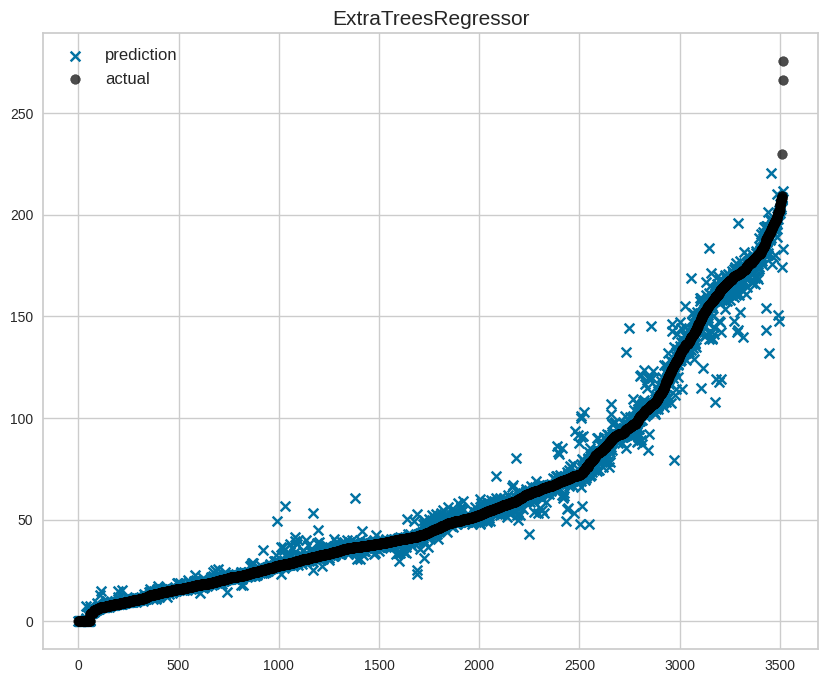

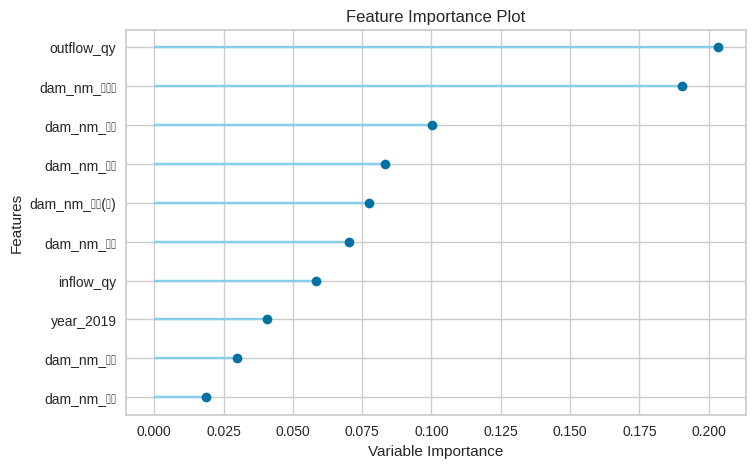

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,58.8525,6081.7735,77.9857,-1.2502,2.3542,0.9168


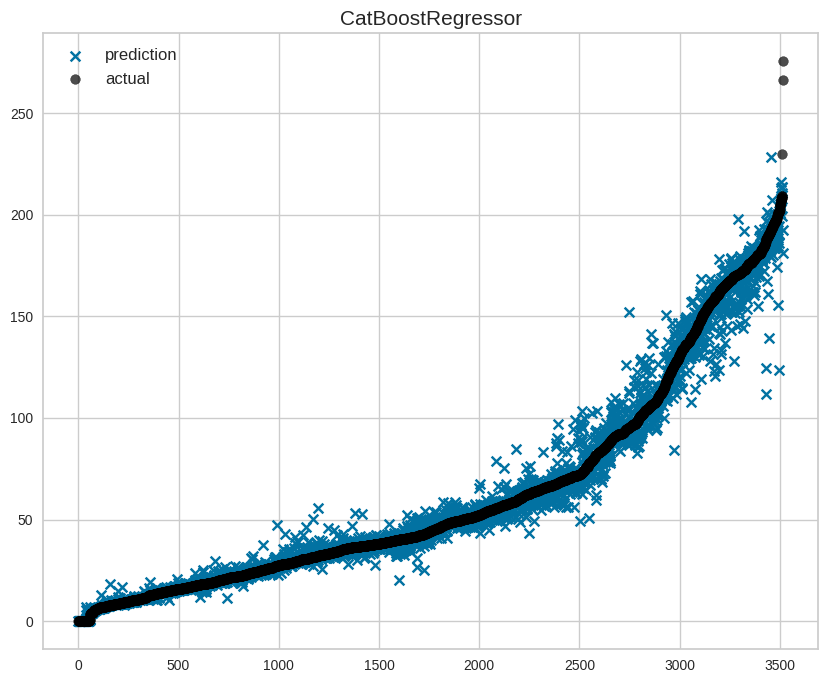

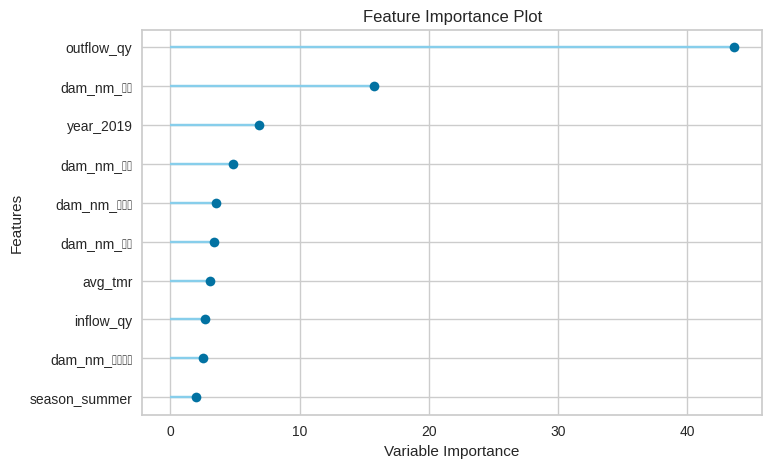

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,58.8558,6081.7296,77.9854,-1.2502,2.3548,0.9064


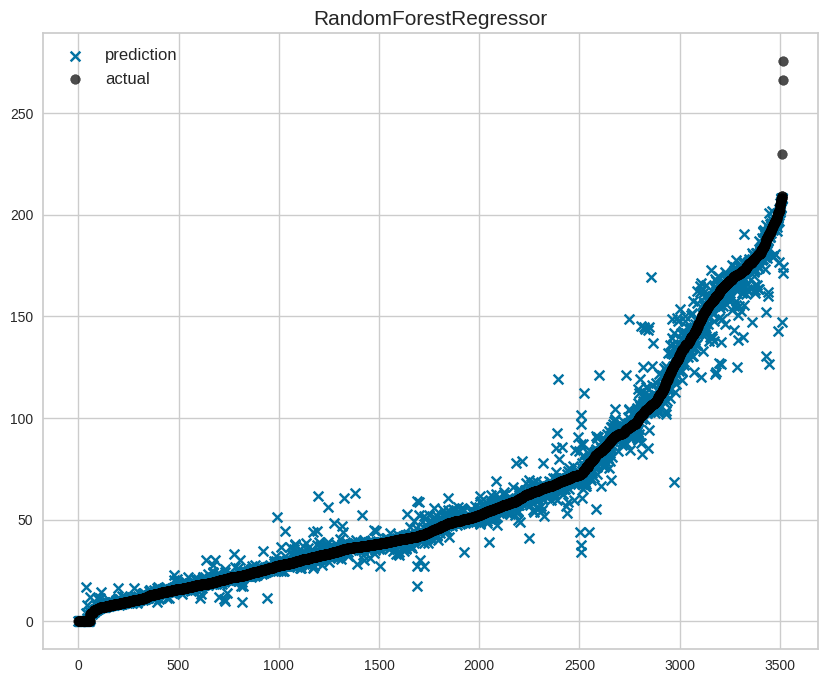

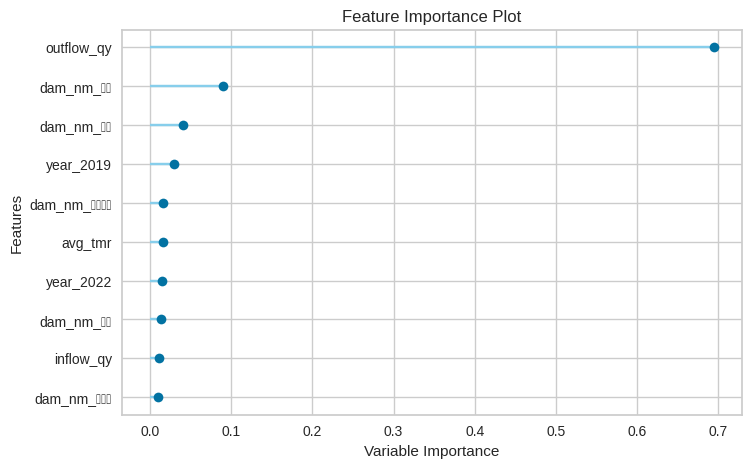

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,58.8563,6082.2480,77.9888,-1.2504,2.3550,0.9320


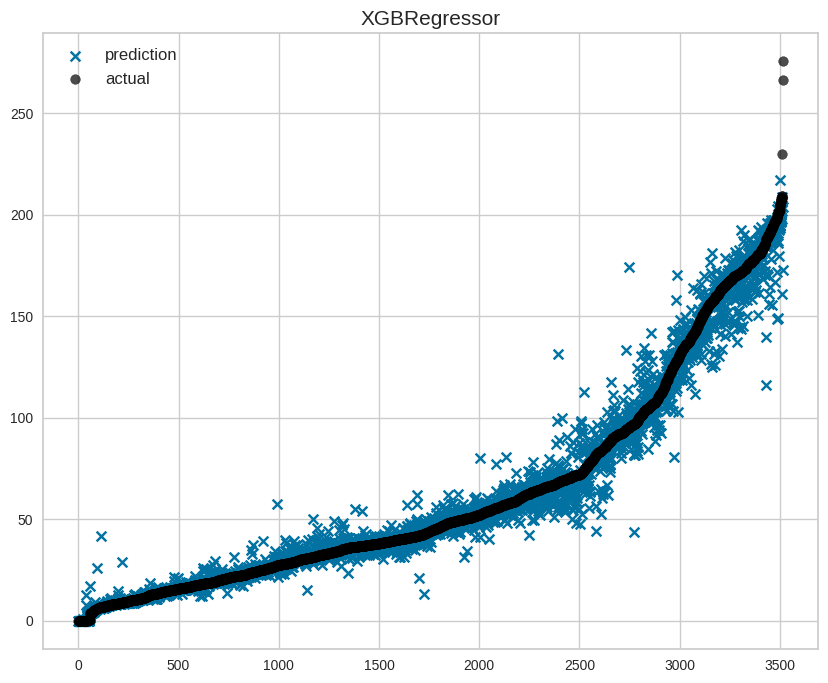

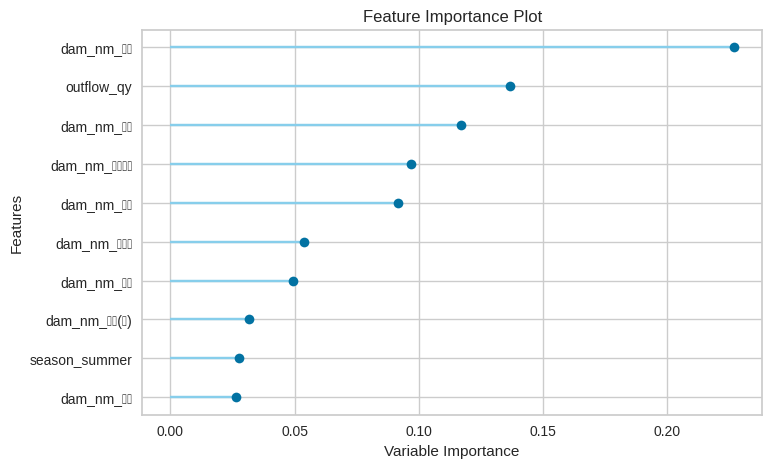

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,58.8540,6081.4582,77.9837,-1.2501,2.3548,0.8956


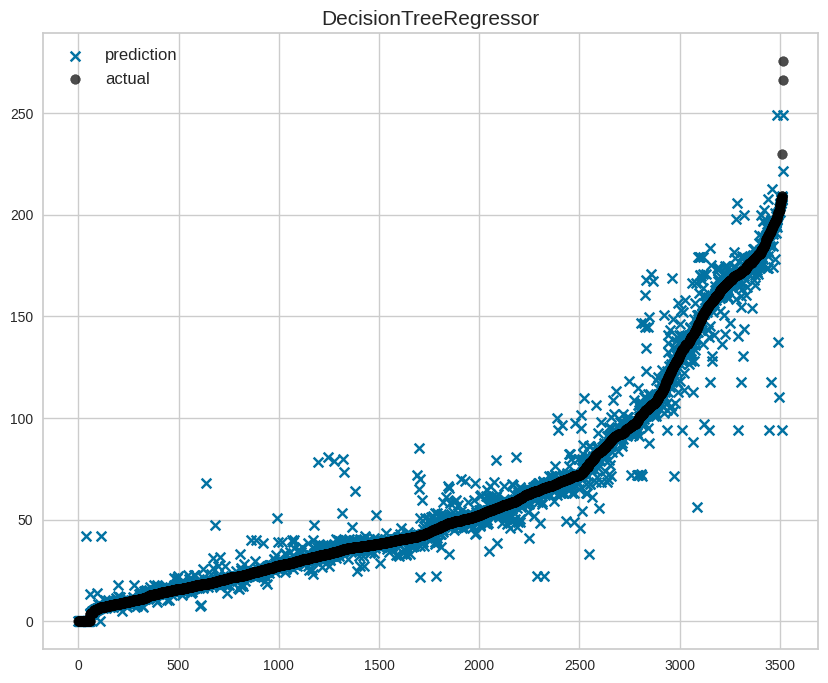

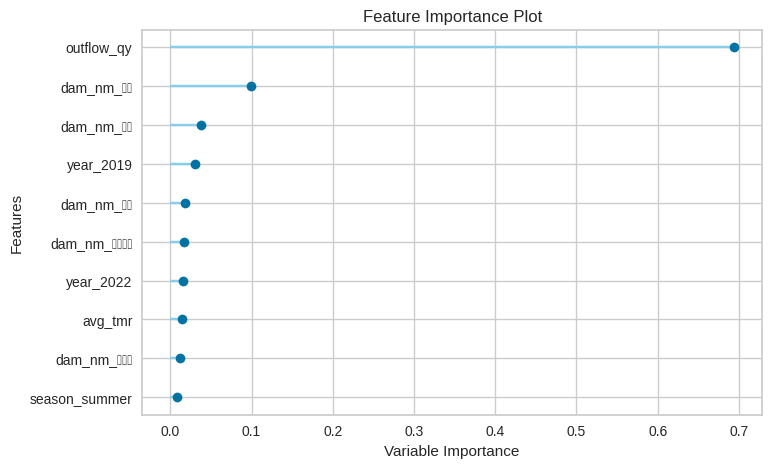

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,58.8563,6082.9285,77.9931,-1.2506,2.3552,0.9333


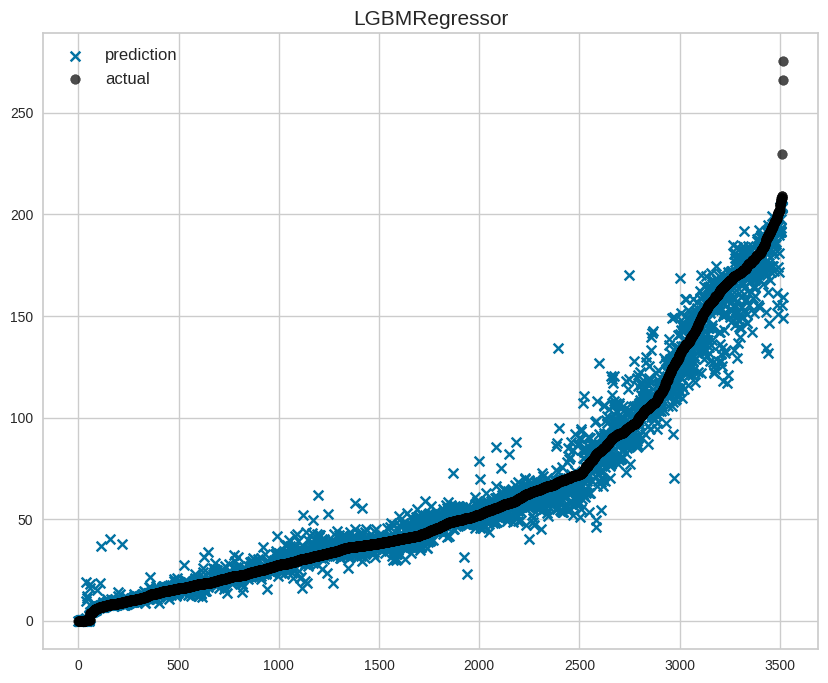

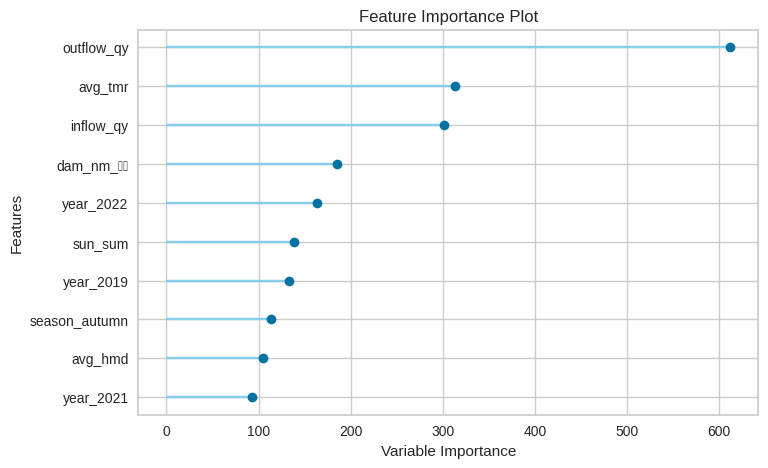

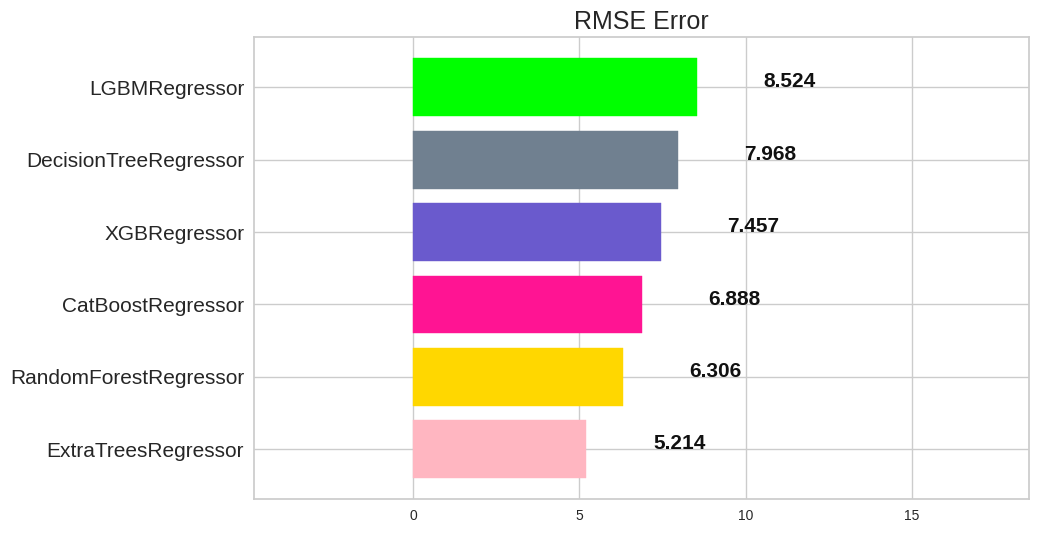


                           rmse  Adjusted R_2
ExtraTreesRegressor    5.213858      0.989899
RandomForestRegressor  6.305865      0.985225
CatBoostRegressor      6.888301      0.982369
XGBRegressor           7.457099      0.979337
DecisionTreeRegressor  7.968402      0.976406
LGBMRegressor          8.524440      0.972999


In [21]:
# 모델 예측
# 각 모델에 대한 예측 수행 및 시각화

my_predictions = {}
for model in best_models1:
    predictions = predict_model(model, data = group1_te)
    # group1의 target 변수는 로그 변환되어 있기에 원래 스케일로 원복해야 함
    model_eval(model.__class__.__name__, np.expm1(predictions['prediction_label']), predictions['reserve_qy'])
    # 모델의 피처 중요도 시각화
    plot_model(model, plot='feature')

    print()

# 모든 모델의 평가 결과 시각화 및 출력
visualize_model_evaluations()

## **Group 2**

In [22]:
group2_tr = train_groups[1]
group2_te = test_groups[1]

In [23]:
group2_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rain_qy         2241 non-null   float64
 1   inflow_qy       2241 non-null   float64
 2   outflow_qy      2241 non-null   float64
 3   reserve_qy      2241 non-null   float64
 4   reserve_rt      2241 non-null   float64
 5   tot_qy          2241 non-null   float64
 6   valid_qy        2241 non-null   float64
 7   unused_qy       2241 non-null   float64
 8   maximum_use_qy  2241 non-null   float64
 9   avg_hmd         2241 non-null   float64
 10  avg_tmr         2241 non-null   float64
 11  avg_wv          2241 non-null   float64
 12  sun_sum         2241 non-null   float64
 13  dam_nm_소양강      2241 non-null   int64  
 14  dam_nm_충주       2241 non-null   int64  
 15  year_2019       2241 non-null   int64  
 16  year_2020       2241 non-null   int64  
 17  year_2021       2241 non-null   i

In [24]:
group2_tr.describe()

,rain_qy,inflow_qy,outflow_qy,reserve_qy,reserve_rt,tot_qy,valid_qy,unused_qy,maximum_use_qy,avg_hmd,...,dam_nm_소양강,dam_nm_충주,year_2019,year_2020,year_2021,year_2022,season_autumn,season_spring,season_summer,season_winter
count,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,...,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000,2241.000000
mean,0.529582,3.617504,4.232899,1616.782075,0.571687,2824.765730,1844.326640,622.915663,1830.548416,0.688340,...,0.498438,0.501562,0.239179,0.257474,0.251673,0.251673,0.253012,0.247657,0.251227,0.248104
std,0.999326,1.309580,0.774461,278.913606,0.095313,75.016373,55.512116,27.005894,78.812223,0.133449,...,0.500109,0.500109,0.426677,0.437340,0.434071,0.434071,0.434835,0.431748,0.433816,0.432009
min,0.000000,0.000000,2.498152,848.952100,0.308700,2750.000000,1789.000000,596.000000,1538.000000,0.316000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.820843,3.835854,1460.897600,0.516000,2750.000000,1789.000000,596.000000,1789.000000,0.589000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.561529,4.262793,1639.560000,0.575000,2750.000000,1789.000000,596.000000,1789.000000,0.703000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.531980,4.370662,4.457111,1811.398400,0.638000,2900.000000,1900.000000,650.000000,1900.000000,0.788000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,4.921199,8.380398,8.284316,2416.721000,0.833000,2900.000000,1900.000000,650.000000,1900.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
from pycaret.regression import *

data2 = group2_tr.drop(columns = ['reserve_rt', 'tot_qy', 'valid_qy', 'unused_qy', 'maximum_use_qy'])

# PyCaret 설정 초기화
exp2 = setup(data = data2, target = 'reserve_qy', preprocess = False, session_id = 42)

,Description,Value
0,Session id,42
1,Target,reserve_qy
2,Target type,Regression
3,Original data shape,"(2241, 18)"
4,Transformed data shape,"(2241, 18)"
5,Transformed train set shape,"(1568, 18)"
6,Transformed test set shape,"(673, 18)"
7,Numeric features,17


In [26]:
# 모델 생성 및 비교
best_models2 = compare_models(sort = 'RMSE', cross_validation = True, n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,34.6611,3398.1364,57.7325,0.9563,0.0386,0.0230,1.0930
catboost,CatBoost Regressor,47.1865,4767.9779,68.6755,0.9383,0.0458,0.0311,3.9590
rf,Random Forest Regressor,44.5915,5011.9384,70.2862,0.9355,0.0478,0.0297,1.2800
xgboost,Extreme Gradient Boosting,50.3584,5781.8484,75.7080,0.9247,0.0509,0.0334,0.5160
lightgbm,Light Gradient Boosting Machine,52.9431,6351.8175,79.3183,0.9176,0.0535,0.0352,1.0880
dt,Decision Tree Regressor,53.8798,10325.1781,100.9816,0.8642,0.0690,0.0353,0.0540
gbr,Gradient Boosting Regressor,77.2959,11022.8787,104.5753,0.8573,0.0725,0.0519,0.4040
knn,K Neighbors Regressor,99.4711,20775.9950,143.4208,0.7327,0.0971,0.0666,0.0450
ada,AdaBoost Regressor,135.6839,25352.7128,159.0266,0.6699,0.1069,0.0899,0.2780
br,Bayesian Ridge,151.1001,33985.0908,184.1692,0.5560,0.1219,0.0995,0.0590


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [27]:
# 각 모델의 튜닝된 파라미터 값 확인
for model in best_models2:
    # 모델의 파라미터 확인
    model_params = model.get_params()
    print(model)
    print(model_params)
    print()

ExtraTreesRegressor(n_jobs=-1, random_state=42)
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 42}

RandomForestRegressor(n_jobs=-1, random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

XGBRegressor(base_score=None, booster='gbtree',

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,34.8023,3310.0137,57.5327,0.9588,0.0385,0.0233


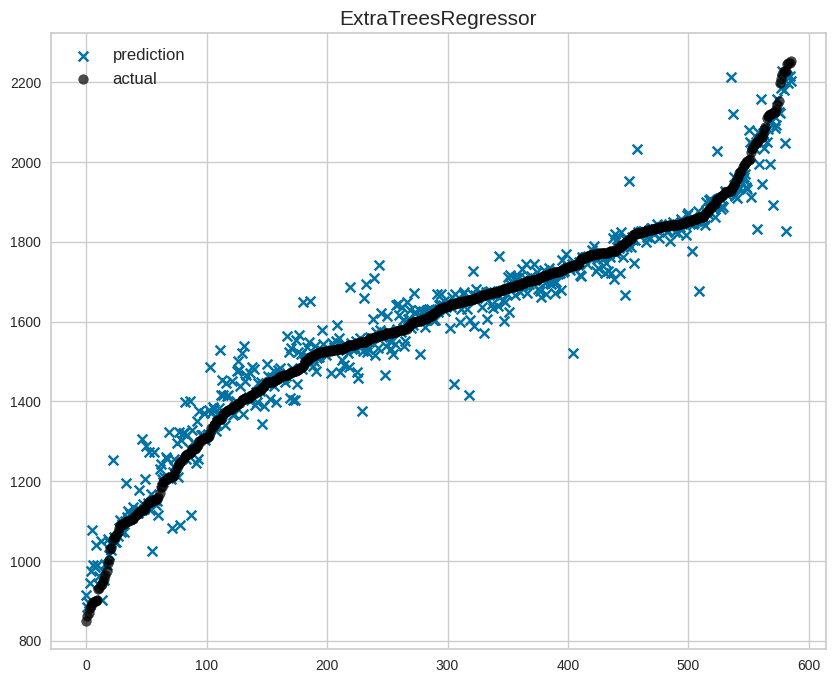

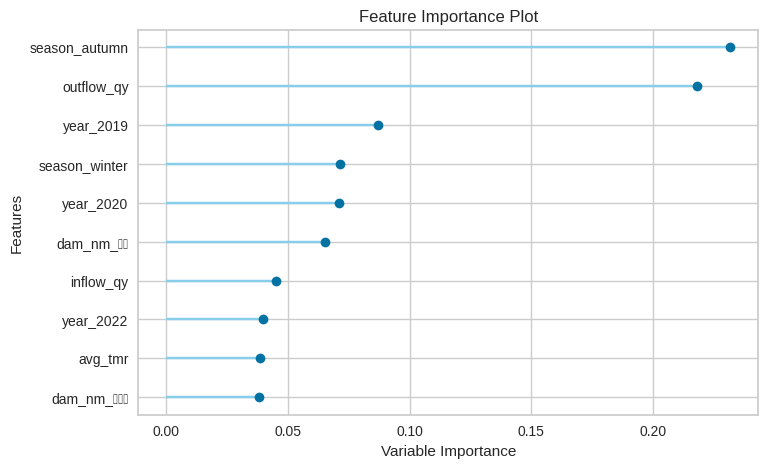

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,49.4183,5123.2153,71.5766,0.9363,0.0491,0.0334


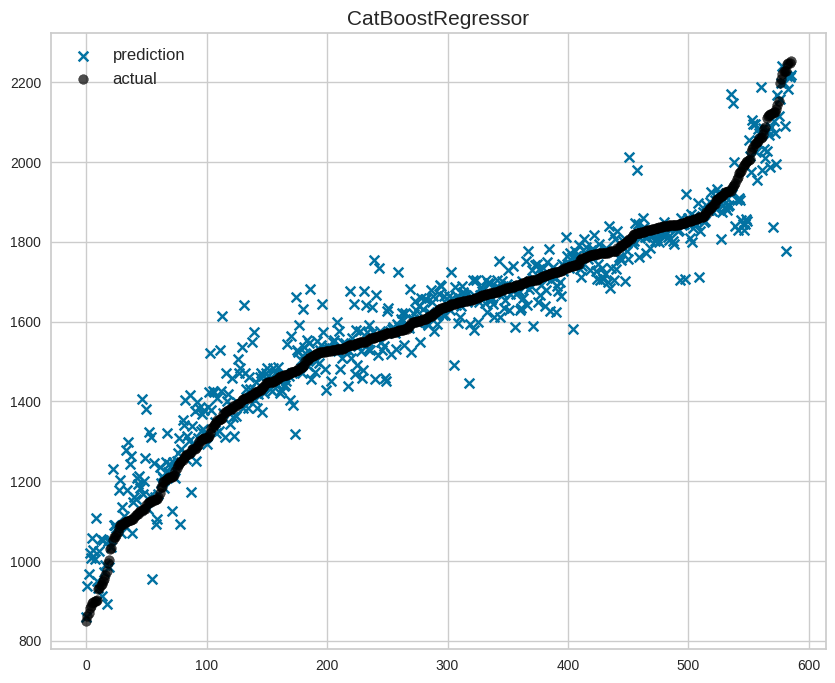

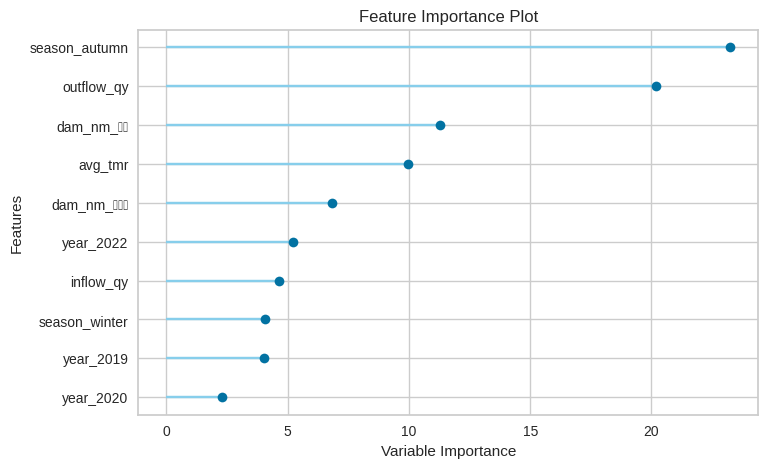

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,45.1071,5033.2896,70.9457,0.9374,0.0489,0.0308


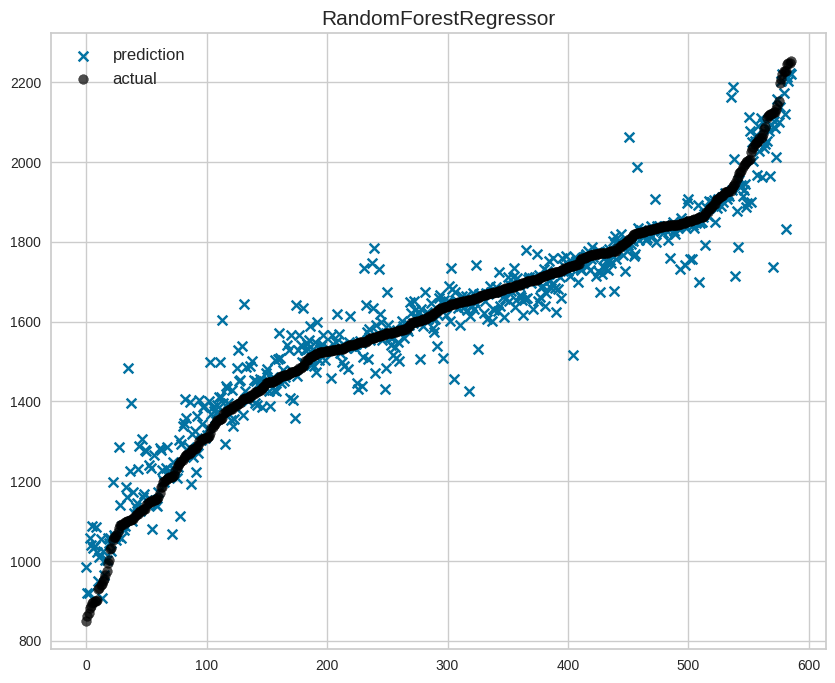

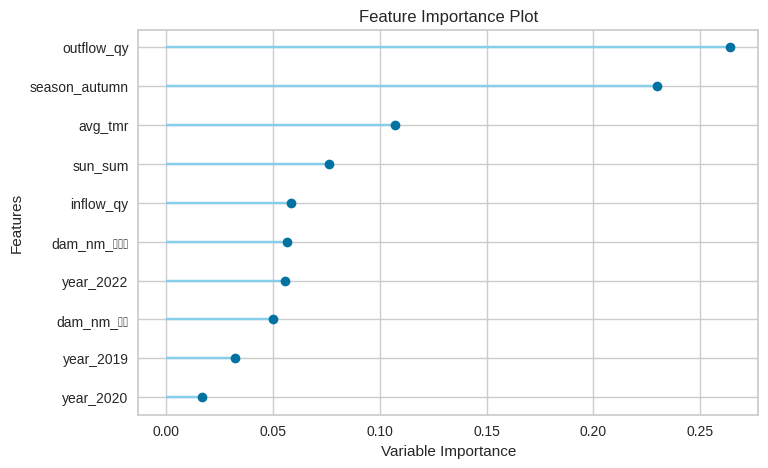

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,50.7574,5720.4658,75.6338,0.9289,0.0529,0.0345


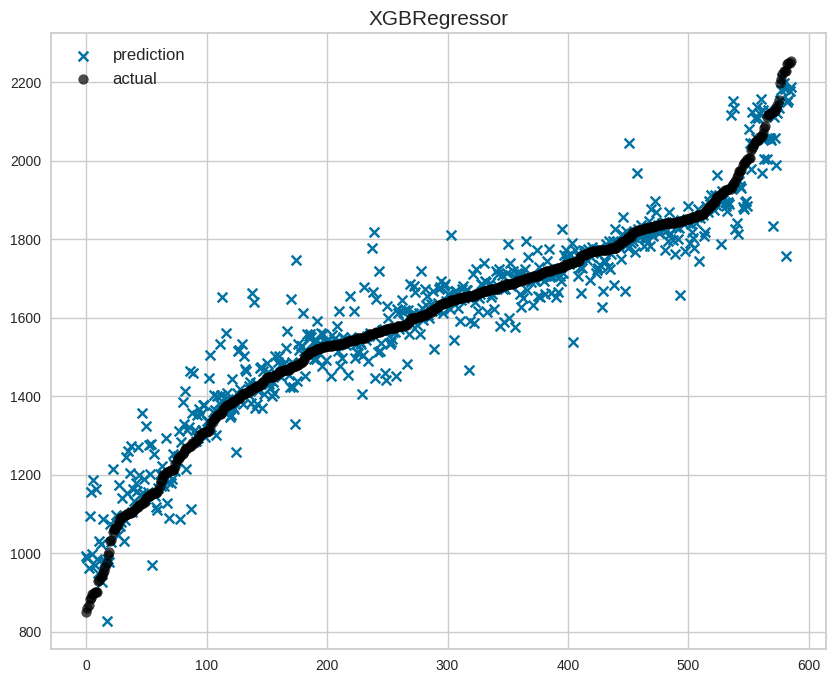

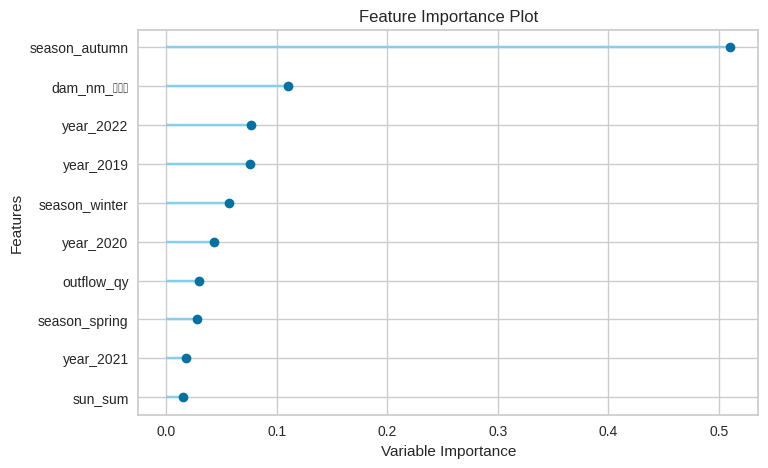

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,54.8653,6317.6834,79.4839,0.9214,0.0548,0.0371


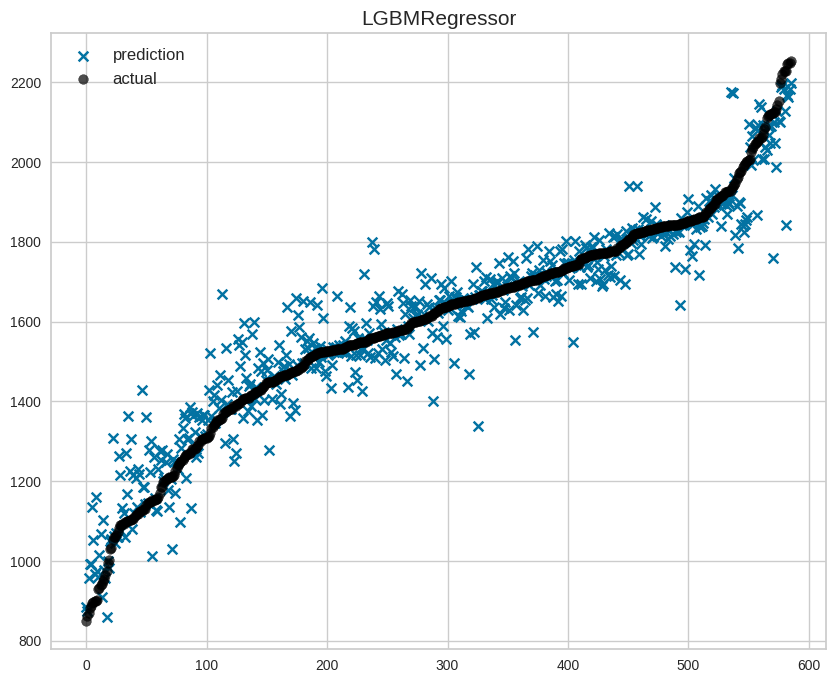

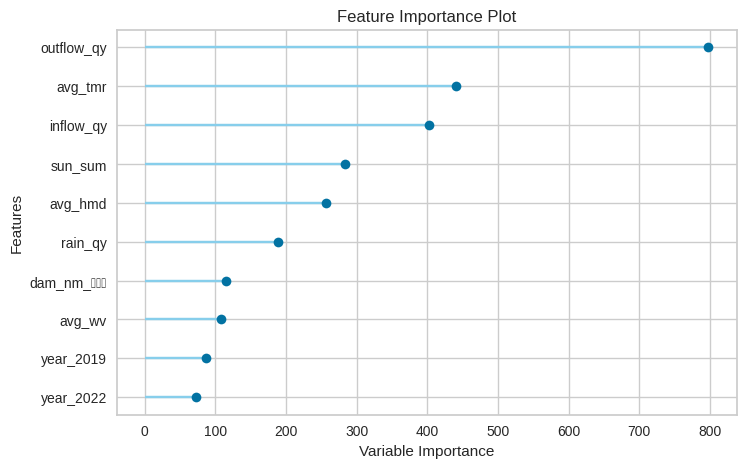

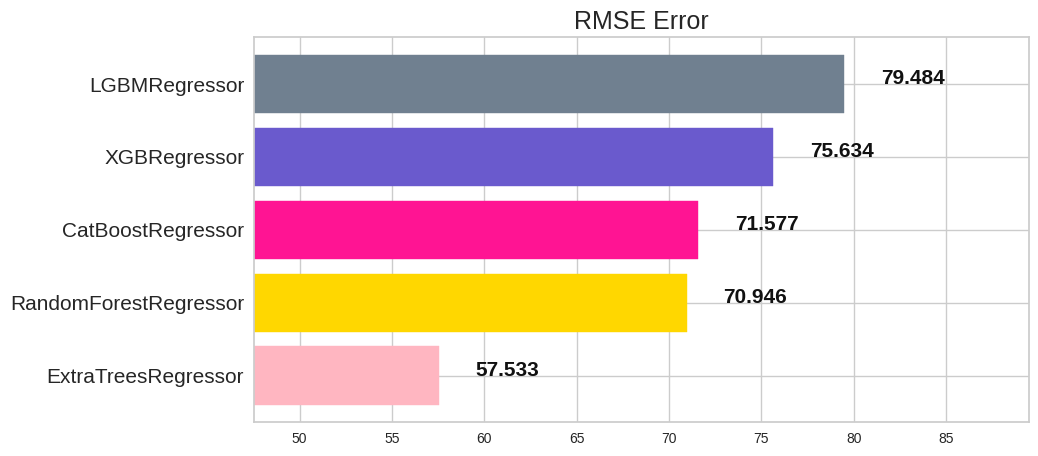


                            rmse  Adjusted R_2
ExtraTreesRegressor    57.532719      0.957760
RandomForestRegressor  70.945681      0.935768
CatBoostRegressor      71.576640      0.934621
XGBRegressor           75.633759      0.926999
LGBMRegressor          79.483856      0.919378


In [28]:
# 모델 예측
# 각 모델에 대한 예측 수행 및 시각화

my_predictions = {}
for model in best_models2:
    predictions = predict_model(model, data = group2_te)
    model_eval(model.__class__.__name__, predictions['prediction_label'], predictions['reserve_qy'])
    # 모델의 피처 중요도 시각화
    plot_model(model, plot='feature')

    print()

# 모든 모델의 평가 결과 시각화 및 출력
visualize_model_evaluations()

## **Group 3**

In [29]:
group3_tr = train_groups[2]
group3_te = test_groups[2]

In [30]:
group3_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5589 entries, 0 to 5588
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rain_qy         5589 non-null   float64
 1   inflow_qy       5589 non-null   float64
 2   outflow_qy      5589 non-null   float64
 3   reserve_qy      5589 non-null   float64
 4   reserve_rt      5589 non-null   float64
 5   tot_qy          5589 non-null   float64
 6   valid_qy        5589 non-null   float64
 7   unused_qy       5589 non-null   float64
 8   maximum_use_qy  5589 non-null   float64
 9   avg_hmd         5589 non-null   float64
 10  avg_tmr         5589 non-null   float64
 11  avg_wv          5589 non-null   float64
 12  sun_sum         5589 non-null   float64
 13  dam_nm_섬진강      5589 non-null   int64  
 14  dam_nm_용담       5589 non-null   int64  
 15  dam_nm_임하       5589 non-null   int64  
 16  dam_nm_주암(본)    5589 non-null   int64  
 17  dam_nm_합천       5589 non-null   i

In [31]:
group3_tr.describe()

,rain_qy,inflow_qy,outflow_qy,reserve_qy,reserve_rt,tot_qy,valid_qy,unused_qy,maximum_use_qy,avg_hmd,...,dam_nm_주암(본),dam_nm_합천,year_2019,year_2020,year_2021,year_2022,season_autumn,season_spring,season_summer,season_winter
count,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.00000,5589.000000,5589.000000,...,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000,5589.000000
mean,0.480046,1.919669,2.680403,367.839132,0.577281,623.631777,487.131508,78.57309,485.789229,0.700318,...,0.201109,0.195205,0.241009,0.256218,0.249240,0.253534,0.252460,0.249776,0.249955,0.247808
std,0.972959,1.133572,0.695170,161.430589,0.165830,153.524868,114.402424,51.90736,113.533464,0.145172,...,0.400865,0.396394,0.427734,0.436582,0.432611,0.435073,0.434463,0.432922,0.433026,0.431778
min,0.000000,0.000000,0.000000,81.409000,0.174700,457.000000,352.000000,6.70000,352.000000,0.008000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.193013,2.280544,257.770000,0.456300,466.000000,424.000000,45.00000,424.000000,0.604000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.769684,2.693207,319.128000,0.587100,595.000000,429.000000,70.00000,429.000000,0.723000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.327143,2.474520,2.872377,463.034000,0.685000,790.000000,560.000000,124.00000,560.000000,0.804000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,4.900763,7.448463,7.514343,753.723000,0.979000,815.000000,672.000000,150.00000,672.000000,0.999000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [32]:
from pycaret.regression import *

data3 = group3_tr.drop(columns = ['reserve_rt', 'tot_qy', 'valid_qy', 'unused_qy', 'maximum_use_qy'])

# PyCaret 설정 초기화
exp3 = setup(data = data3, target = 'reserve_qy', preprocess = False, session_id = 42)

,Description,Value
0,Session id,42
1,Target,reserve_qy
2,Target type,Regression
3,Original data shape,"(5589, 21)"
4,Transformed data shape,"(5589, 21)"
5,Transformed train set shape,"(3912, 21)"
6,Transformed test set shape,"(1677, 21)"
7,Numeric features,20


In [33]:
# 모델 생성 및 비교
best_models3 = compare_models(sort = 'RMSE', cross_validation = True, n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,9.3089,320.4766,17.7554,0.9878,0.0564,0.0294,1.8320
catboost,CatBoost Regressor,14.8686,464.1784,21.5037,0.9823,0.0732,0.0483,4.4350
rf,Random Forest Regressor,12.5128,537.1007,23.0638,0.9796,0.0689,0.0377,2.4450
xgboost,Extreme Gradient Boosting,16.3648,612.2425,24.6570,0.9767,0.0837,0.0534,1.1270
lightgbm,Light Gradient Boosting Machine,17.2555,647.1585,25.3933,0.9754,0.0818,0.0544,0.4170
dt,Decision Tree Regressor,14.5651,1083.1766,32.7394,0.9589,0.0923,0.0429,0.0810
gbr,Gradient Boosting Regressor,29.6626,1456.6973,38.1297,0.9446,0.1297,0.0959,0.8650
ada,AdaBoost Regressor,48.3028,3329.4476,57.6634,0.8734,0.2112,0.1750,0.4460
ridge,Ridge Regression,48.2697,3677.3955,60.6229,0.8600,0.2009,0.1534,0.0990
br,Bayesian Ridge,48.2746,3677.4002,60.6230,0.8600,0.2009,0.1534,0.1040


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [34]:
# 각 모델의 튜닝된 파라미터 값 확인
for model in best_models3:
    # 모델의 파라미터 확인
    model_params = model.get_params()
    print(model)
    print(model_params)
    print()

ExtraTreesRegressor(n_jobs=-1, random_state=42)
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 42}

RandomForestRegressor(n_jobs=-1, random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

XGBRegressor(base_score=None, booster='gbtree',

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.6597,333.9003,18.2729,0.9873,0.0644,0.0322


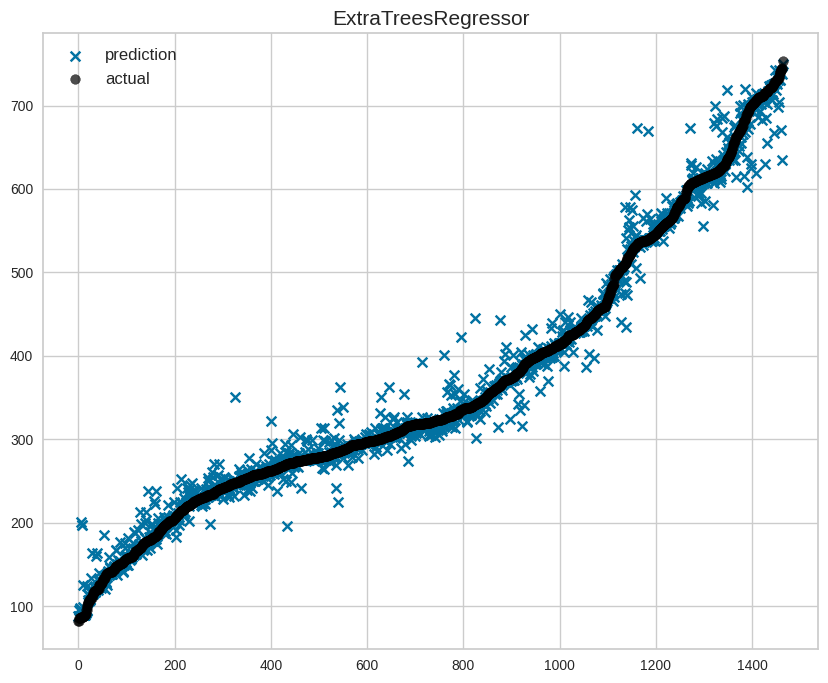

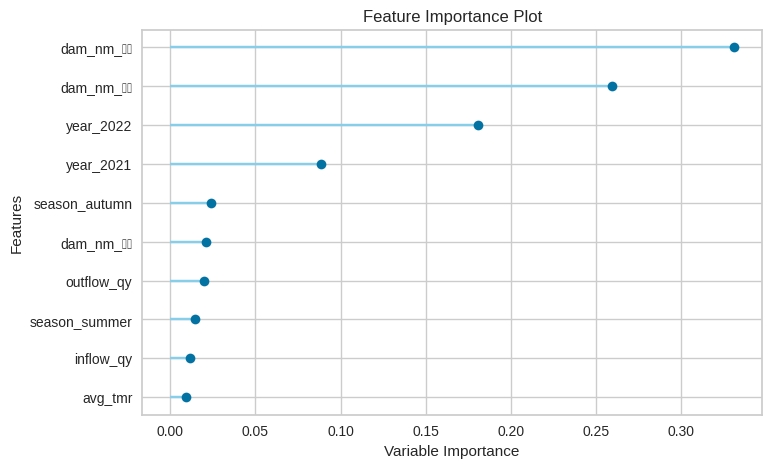

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,15.7296,521.2100,22.8300,0.9801,0.0846,0.0538


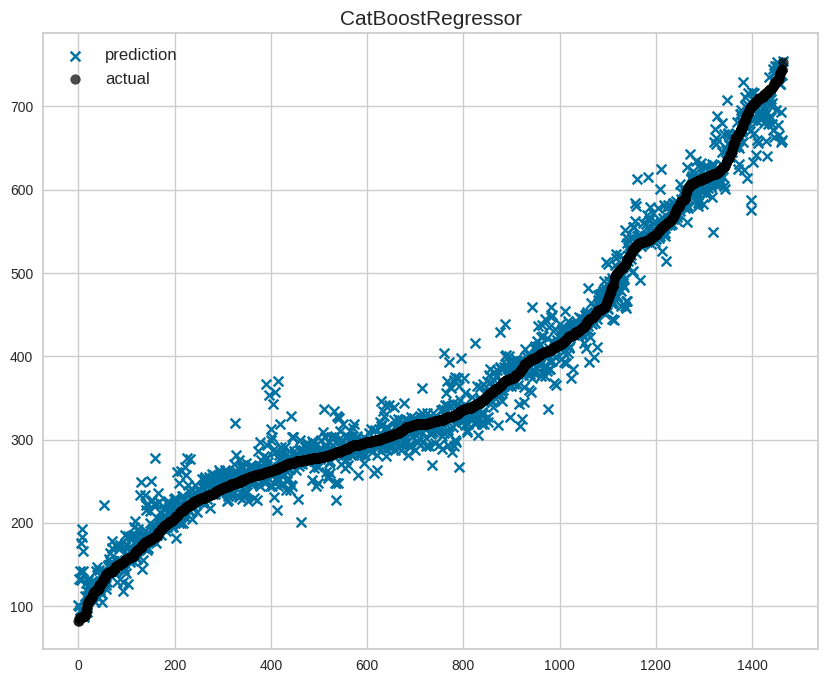

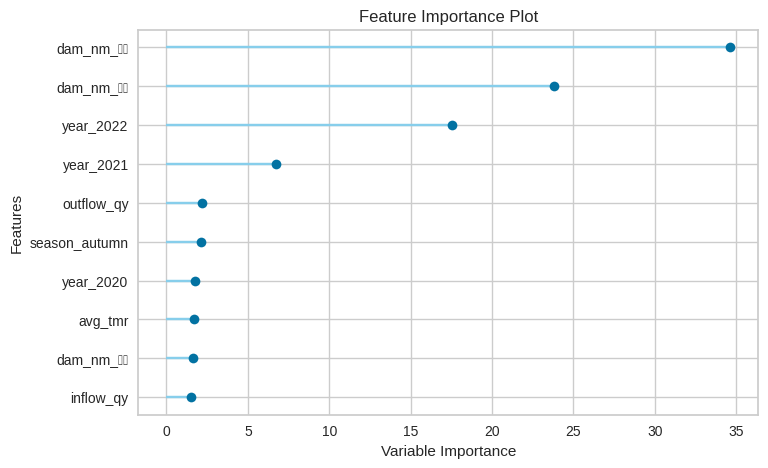

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,12.3939,497.8767,22.3132,0.9810,0.0835,0.0422


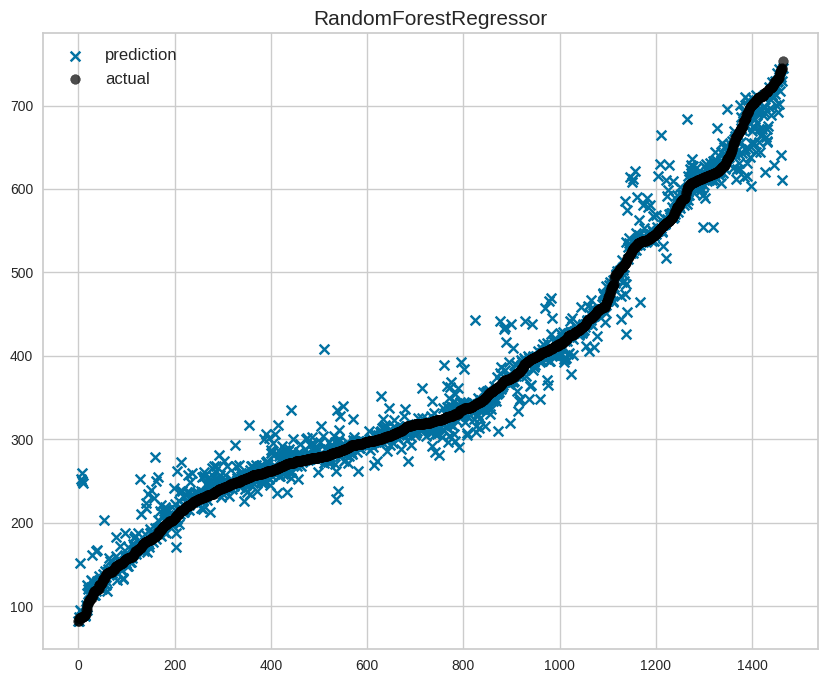

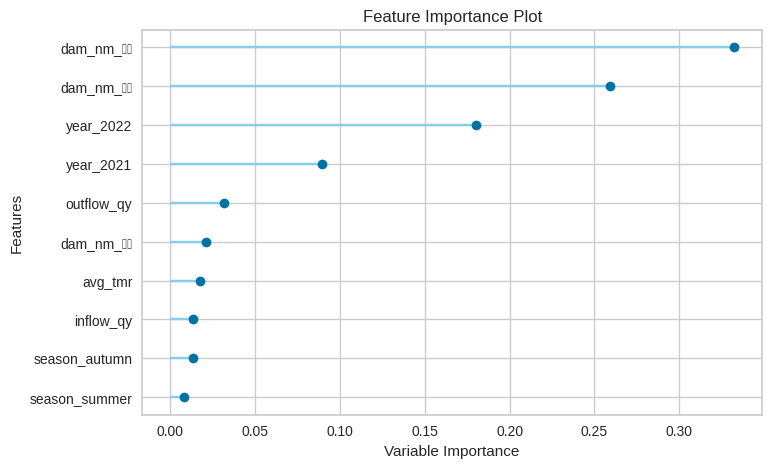

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,16.5768,595.6796,24.4066,0.9773,0.0915,0.0569


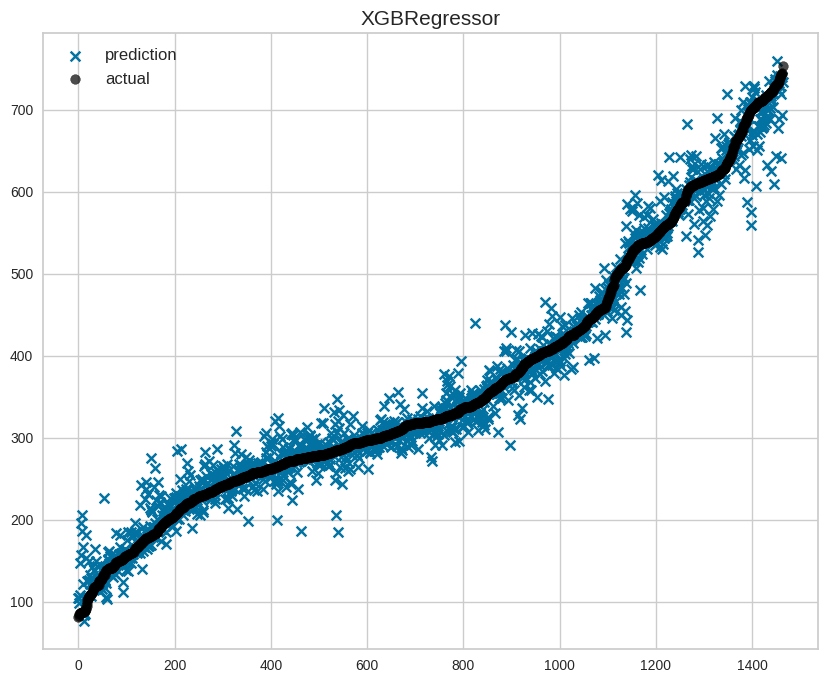

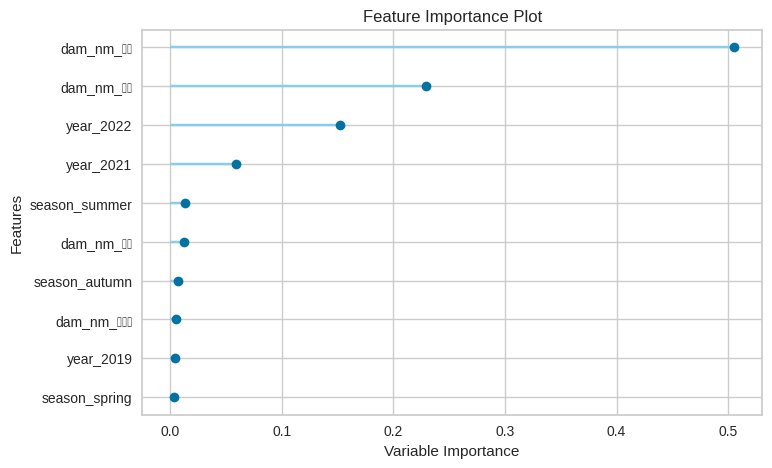

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,17.8168,674.8666,25.9782,0.9743,0.0935,0.0601


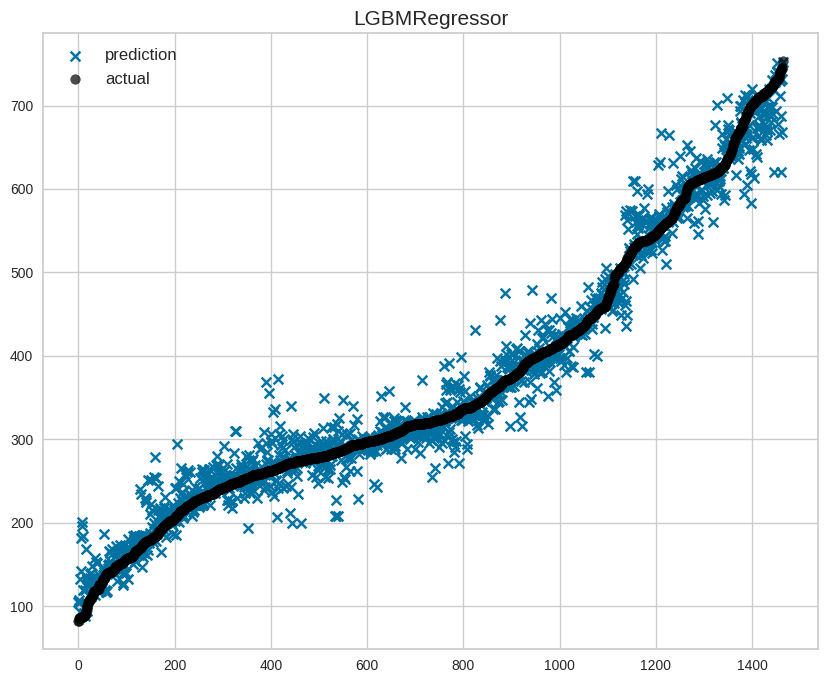

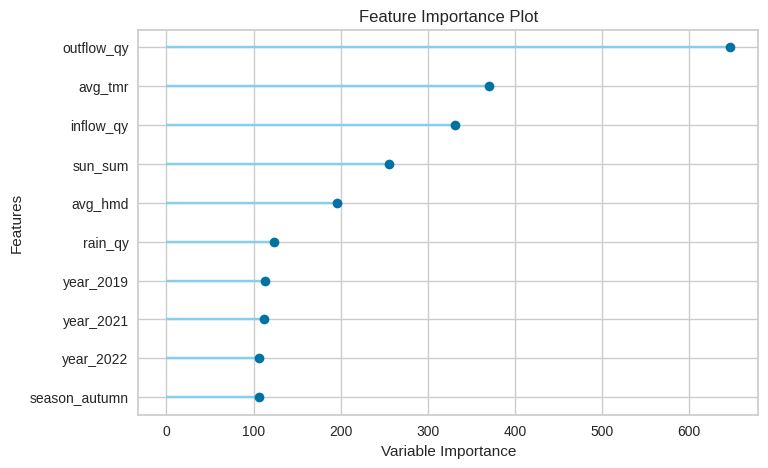

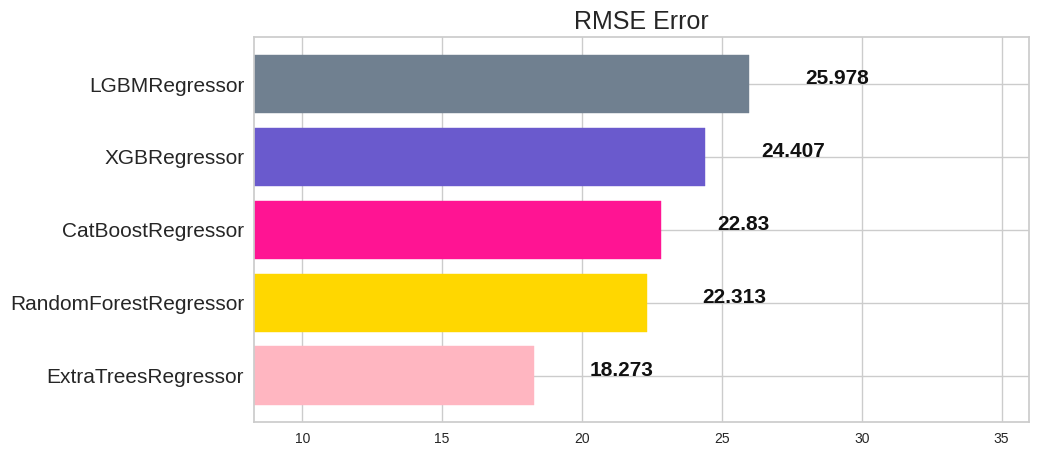


                            rmse  Adjusted R_2
ExtraTreesRegressor    18.272939      0.987148
RandomForestRegressor  22.313150      0.980836
CatBoostRegressor      22.830023      0.979938
XGBRegressor           24.406549      0.977072
LGBMRegressor          25.978194      0.974024


In [35]:
# 모델 예측
# 각 모델에 대한 예측 수행 및 시각화

my_predictions = {}
for model in best_models3:
    predictions = predict_model(model, data = group3_te)
    model_eval(model.__class__.__name__, predictions['prediction_label'], predictions['reserve_qy'])
    # 모델의 피처 중요도 시각화
    plot_model(model, plot='feature')

    print()

# 모든 모델의 평가 결과 시각화 및 출력
visualize_model_evaluations()

## **Group 4**

In [36]:
group4_tr = train_groups[3]
group4_te = test_groups[3]

In [37]:
group4_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246 entries, 0 to 2245
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rain_qy         2246 non-null   float64
 1   inflow_qy       2246 non-null   float64
 2   outflow_qy      2246 non-null   float64
 3   reserve_qy      2246 non-null   float64
 4   reserve_rt      2246 non-null   float64
 5   tot_qy          2246 non-null   float64
 6   valid_qy        2246 non-null   float64
 7   unused_qy       2246 non-null   float64
 8   maximum_use_qy  2246 non-null   float64
 9   avg_hmd         2246 non-null   float64
 10  avg_tmr         2246 non-null   float64
 11  avg_wv          2246 non-null   float64
 12  sun_sum         2246 non-null   float64
 13  dam_nm_대청       2246 non-null   int64  
 14  dam_nm_안동       2246 non-null   int64  
 15  year_2019       2246 non-null   int64  
 16  year_2020       2246 non-null   int64  
 17  year_2021       2246 non-null   i

In [38]:
group4_tr.describe()

,rain_qy,inflow_qy,outflow_qy,reserve_qy,reserve_rt,tot_qy,valid_qy,unused_qy,maximum_use_qy,avg_hmd,...,dam_nm_대청,dam_nm_안동,year_2019,year_2020,year_2021,year_2022,season_autumn,season_spring,season_summer,season_winter
count,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,...,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000,2246.000000
mean,0.483703,2.884908,3.491700,901.754293,0.658952,1369.969724,894.158504,349.809439,890.338379,0.627909,...,0.504007,0.495993,0.236420,0.256011,0.252004,0.255565,0.256011,0.249332,0.244435,0.250223
std,0.975172,1.255794,0.777594,134.619268,0.087435,121.023059,105.020010,101.019248,103.082433,0.143012,...,0.500095,0.500095,0.424978,0.436525,0.434260,0.436276,0.436525,0.432723,0.429847,0.433238
min,0.000000,0.000000,0.000000,519.211700,0.416000,1248.000000,790.000000,248.000000,790.000000,0.235000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.226514,3.167267,821.478000,0.605000,1248.000000,790.000000,248.000000,790.000000,0.525000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.890816,3.469619,912.323150,0.661000,1490.000000,790.000000,450.000000,790.000000,0.638500,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.301400,3.475299,3.749762,997.394000,0.719000,1490.000000,1000.000000,450.000000,1000.000000,0.733750,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.750000
max,4.433372,8.431923,8.094113,1304.602000,0.876000,1490.000000,1000.000000,450.000000,1000.000000,0.965000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
from pycaret.regression import *

data4 = group4_tr.drop(columns = ['reserve_rt', 'tot_qy', 'valid_qy', 'unused_qy', 'maximum_use_qy'])

# PyCaret 설정 초기화
exp4 = setup(data = data4, target = 'reserve_qy', preprocess = False, session_id = 42)

,Description,Value
0,Session id,42
1,Target,reserve_qy
2,Target type,Regression
3,Original data shape,"(2246, 18)"
4,Transformed data shape,"(2246, 18)"
5,Transformed train set shape,"(1572, 18)"
6,Transformed test set shape,"(674, 18)"
7,Numeric features,17


In [40]:
# 모델 생성 및 비교
best_models4 = compare_models(sort = 'RMSE', cross_validation = True, n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,16.6172,786.5286,27.6604,0.9559,0.0308,0.0188,0.7940
catboost,CatBoost Regressor,22.2925,1067.4005,32.4148,0.9400,0.0365,0.0252,3.4750
rf,Random Forest Regressor,20.3444,1154.4028,33.7301,0.9354,0.0374,0.0230,1.1050
lightgbm,Light Gradient Boosting Machine,24.2570,1275.6099,35.6573,0.9281,0.0403,0.0275,0.8320
xgboost,Extreme Gradient Boosting,24.3899,1315.2135,36.0730,0.9260,0.0405,0.0275,0.3430
dt,Decision Tree Regressor,23.0158,2036.6509,44.4769,0.8850,0.0497,0.0261,0.1290
gbr,Gradient Boosting Regressor,35.4744,2179.6710,46.5247,0.8779,0.0534,0.0405,0.6050
ada,AdaBoost Regressor,59.3800,4973.3341,70.4438,0.7208,0.0818,0.0684,0.5720
lr,Linear Regression,67.9024,6856.0973,82.7408,0.6147,0.0951,0.0781,0.0740
ridge,Ridge Regression,67.9245,6856.2700,82.7419,0.6147,0.0952,0.0781,0.0680


Processing:   0%|          | 0/89 [00:00<?, ?it/s]

In [41]:
# 각 모델의 튜닝된 파라미터 값 확인
for model in best_models4:
    # 모델의 파라미터 확인
    model_params = model.get_params()
    print(model)
    print(model_params)
    print()

ExtraTreesRegressor(n_jobs=-1, random_state=42)
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 42}

RandomForestRegressor(n_jobs=-1, random_state=42)
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

LGBMRegressor(n_jobs=-1, random_state=42)
{'boo

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,18.8773,1117.9670,33.4360,0.9445,0.0380,0.0220


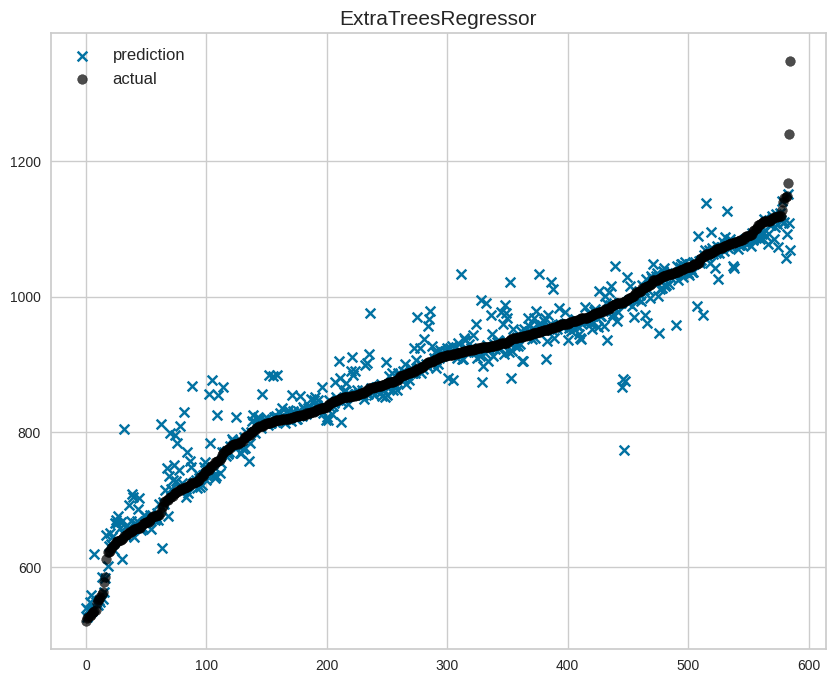

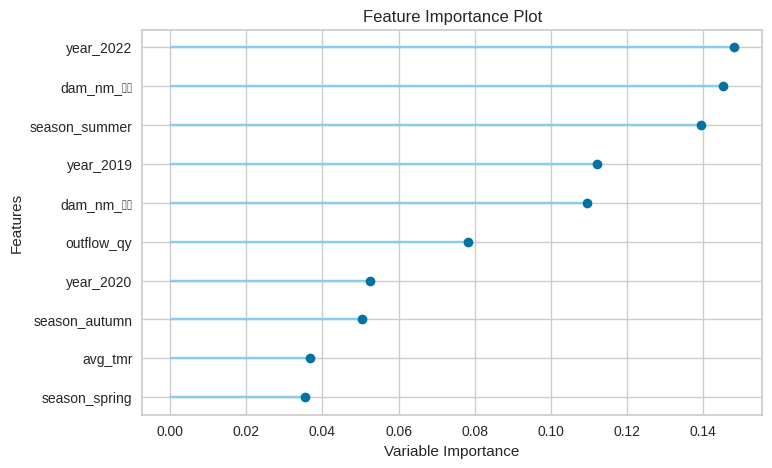

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,24.8037,1530.3957,39.1203,0.9240,0.0447,0.0289


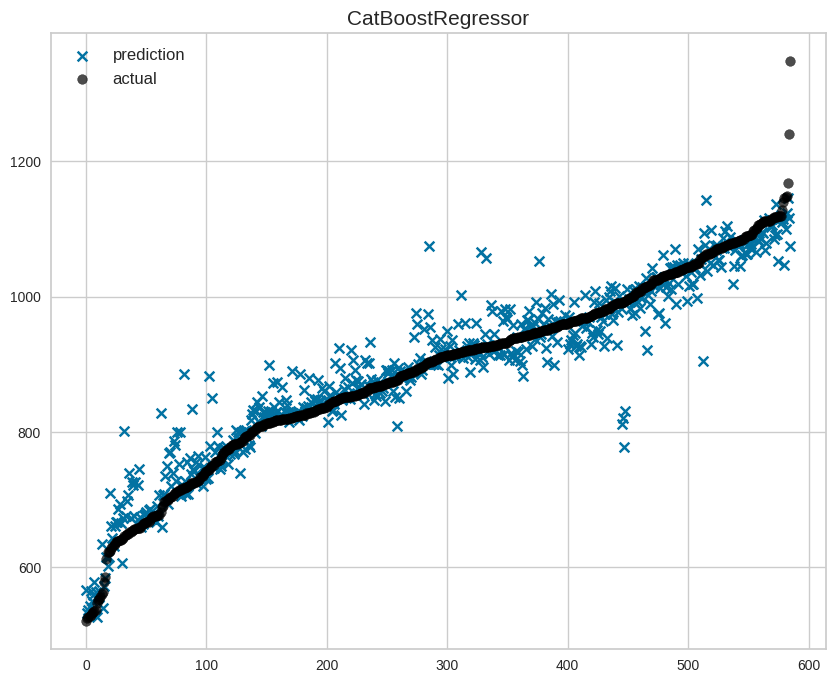

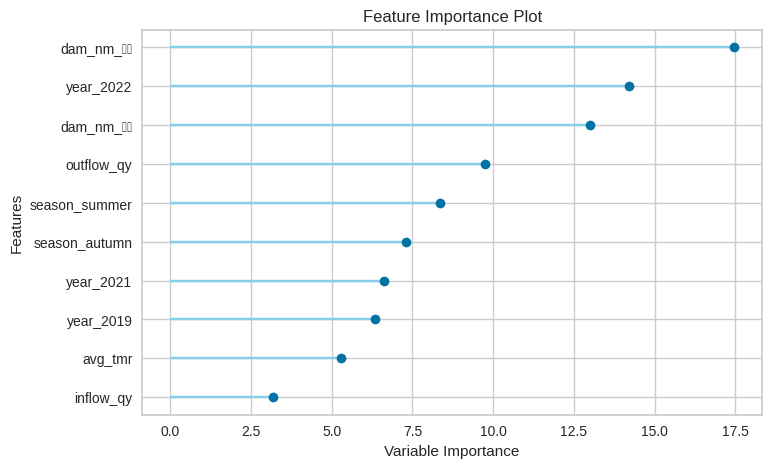

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,21.2480,1463.0796,38.2502,0.9273,0.0433,0.0244


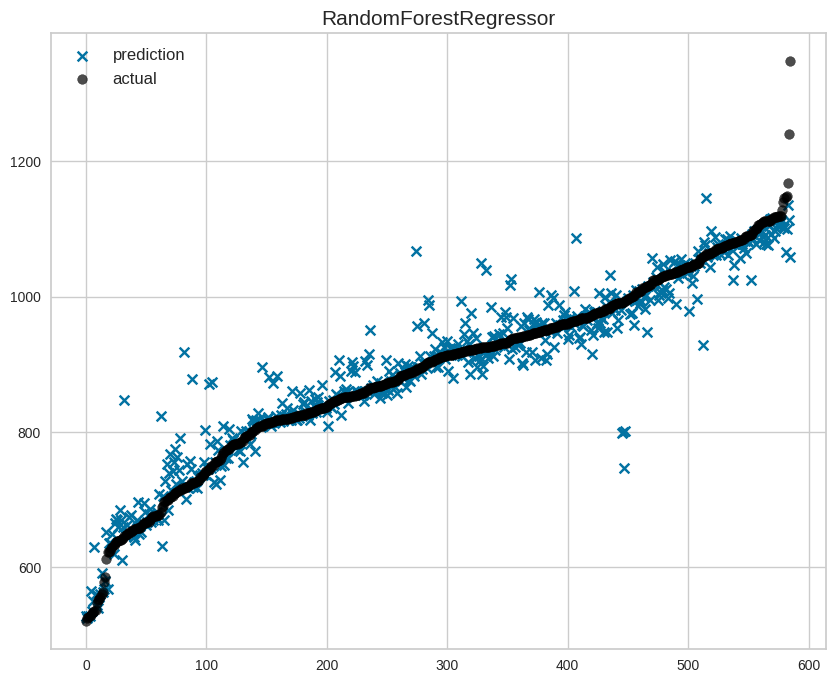

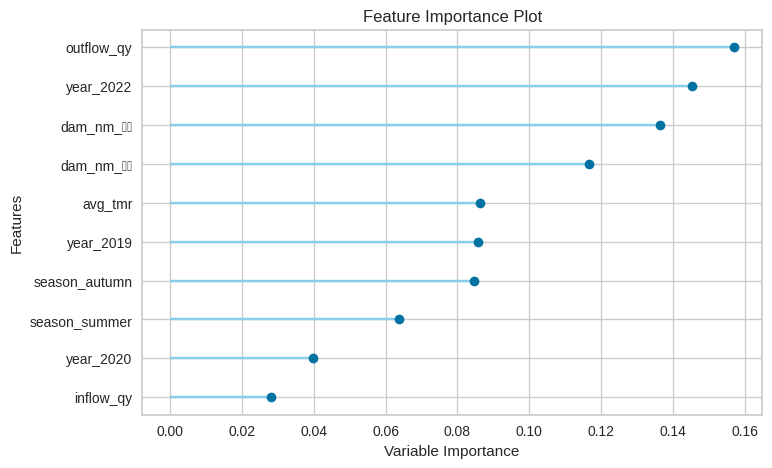

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,26.3754,1589.8226,39.8726,0.9210,0.0450,0.0306


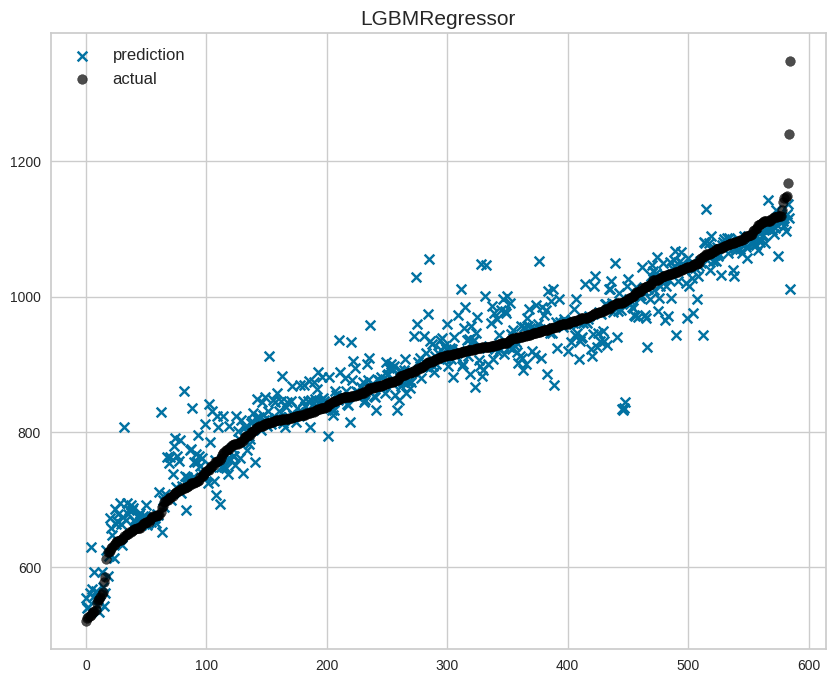

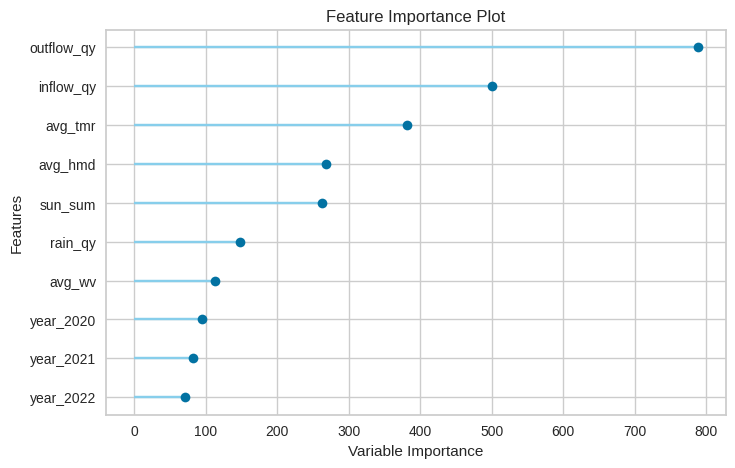

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,26.0023,1714.5400,41.4070,0.9148,0.0478,0.0303


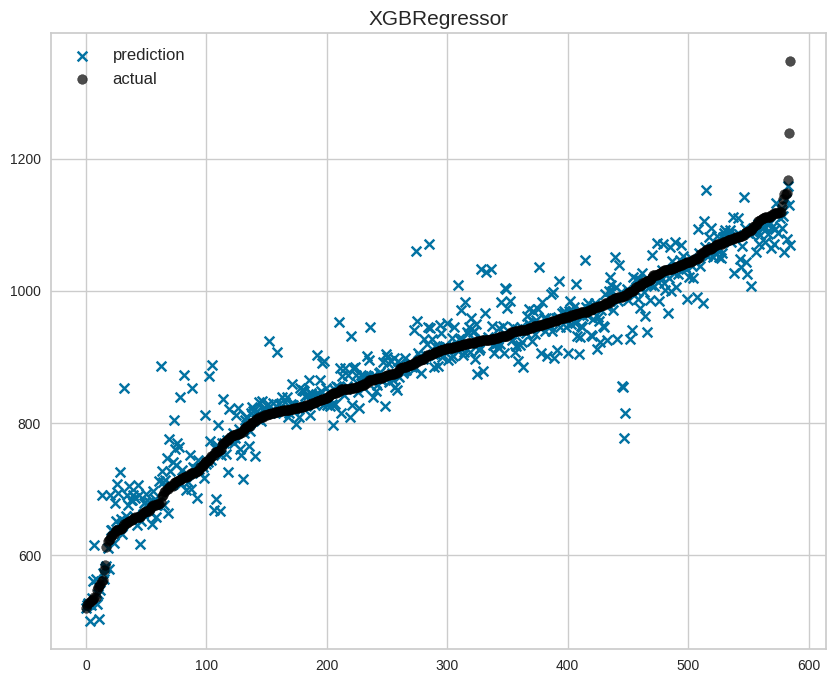

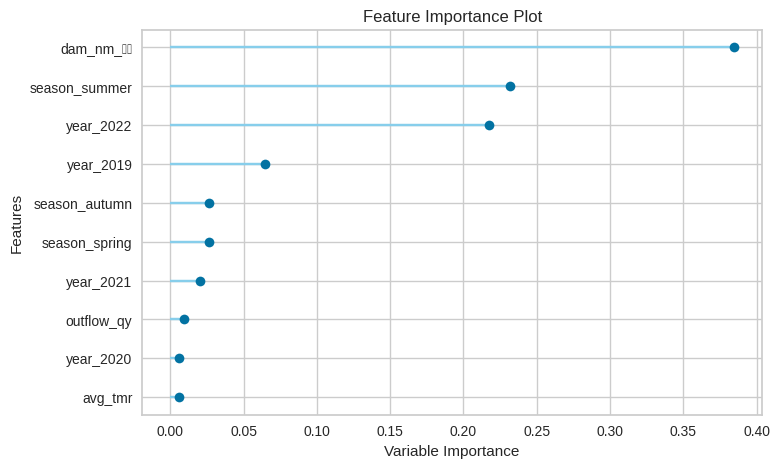

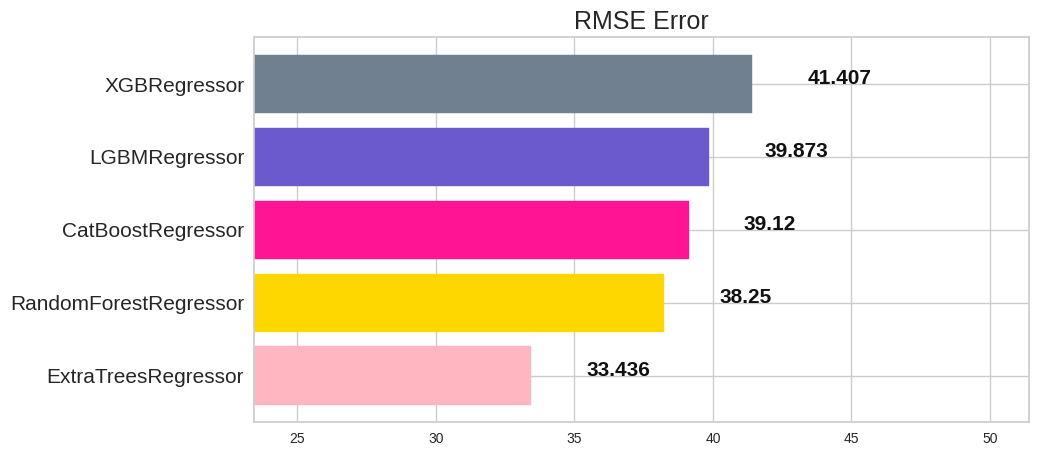


                            rmse  Adjusted R_2
ExtraTreesRegressor    33.436014      0.943001
RandomForestRegressor  38.250223      0.925406
CatBoostRegressor      39.120272      0.921974
LGBMRegressor          39.872580      0.918944
XGBRegressor           41.407001      0.912586


In [42]:
# 모델 예측
# 각 모델에 대한 예측 수행 및 시각화

my_predictions = {}
for model in best_models4:
    predictions = predict_model(model, data = group4_te)
    model_eval(model.__class__.__name__, predictions['prediction_label'], predictions['reserve_qy'])
    # 모델의 피처 중요도 시각화
    plot_model(model, plot='feature')

    print()

# 모든 모델의 평가 결과 시각화 및 출력
visualize_model_evaluations()